In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

from graph_utils import *
from performance_utils import *
from metropolis import *
from houdayer_algorithm import *
from sim_util import *

Specs:
  Number of nodes (N) = 800
  Degree of graph (d) = 5
  Intra-group connect param (a) = 9.990009990009991
  Inter-group connect param (b) = 0.009990009990009992
  Group connect ratio (r) = b/a = 0.001
  Critical ratio (rc) = 0.38196601125010515 (for detectable communities)


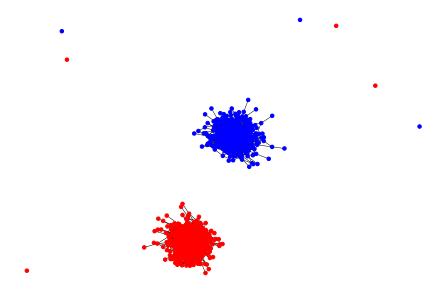

In [2]:
# Initialize random seed
np.random.seed(0)

# Define the parameters
N = 800      # number of nodes
d = 5       # degree

# Generate the basic parameters for simulation
a, b, r = generate_detectable_a_b(d, r=1e-3)
display_spec(N,d,a,b,r)

true_group_label = generate_population(N)
G = graph_gen(true_group_label, a, b)

draw_graph(G, true_group_label)

## Start Simulation

In [3]:
# Initialize the vector to start searching
x1_init, x2_init = generate_population(N), generate_population(N)
# Obtain the adjacency matrix
Adj = nx.to_numpy_array(G)

chain_1 = Metropolis(Adj, a, b, x1_init)
chain_2 = Metropolis(Adj, a, b, x2_init)

In [8]:
chain_1.reset();chain_2.reset()
ov1, ov2 = sim_one_round(G, chain_1, chain_2, true_group_label, 10000, 20, 1)

100%|██████████| 10000/10000 [00:17<00:00, 560.57it/s]


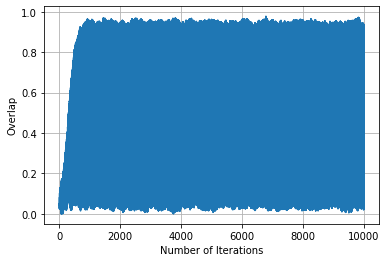

In [9]:
plot_sim(ov1, 'Number of Iterations', 'Overlap')

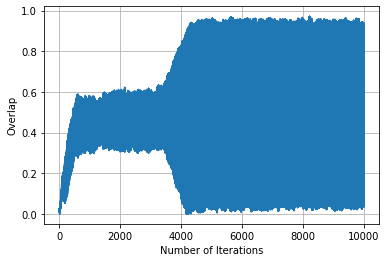

In [10]:
plot_sim(ov2, 'Number of Iterations', 'Overlap')